# Simple regression: Don't think too hard!

## Web traffic data: Load & Cleaning

We load some data tracking the number of hits per hour on a fictional website.

Is our fictional start up web service taking off?

In [11]:
import os.path
import scipy as sp
import matplotlib.pyplot as plt

# os.getcwd() returns the valuye of the 'current directory', the one you started your notebook in.
# You shd have the data file in your notebook directory.  But you can place
# it somewhere else if you like, and change the value of data_dir
data_dir = os.getcwd()
data = sp.genfromtxt(os.path.join(data_dir, "web_traffic.tsv"), 
                     delimiter="\t")
print((data[:10]))

x_init = data[:, 0]
y_init = data[:, 1]
print("Number of invalid entries:", sp.sum(sp.isnan(y_init)))
x = x_init[~sp.isnan(y_init)]
y = y_init[~sp.isnan(y_init)]

default_title = "Web traffic over the last month"

[[1.000e+00 2.272e+03]
 [2.000e+00       nan]
 [3.000e+00 1.386e+03]
 [4.000e+00 1.365e+03]
 [5.000e+00 1.488e+03]
 [6.000e+00 1.337e+03]
 [7.000e+00 1.883e+03]
 [8.000e+00 2.283e+03]
 [9.000e+00 1.335e+03]
 [1.000e+01 1.025e+03]]
Number of invalid entries: 8


The data is pretty simple, a table with two columns.  The first column is the hour number, counting hours
from the moment our fictional startup fictionally started up.  THe second column is the number of hits for that hour.
Note that some of the entries in the second column are not a number. They are `nan`, for instance, for
hour number 2.  The label `nan` stands
for "not a number".  This is a standard return value for operations which are supposed to return a number, which, for some reason, cannot do so.  In this case the most likely explanation is that there was an internet glitch, and the website was not in operation for that hour.

This code prints the number of nan entries in the second column and then removes the nan entries
from both the fist and second column.

Based on what you learned about indexing arrays, say what parts of the data `x` and `y` are:

```
x = data[:, 0]
y = data[:, 1]
```

If you said `x` is the first column and `y` is the second, gold star.    Notice that `x` and `y` are both just
1D arrays.  Nothing about them tells whether they came from columns or rows.

```
print "Number of invalid entries:", sp.sum(sp.isnan(y))
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]
```

Look at the output of the code below and note that `sp.isnan(y)` returns an array of truth values (**Booleans**).  
Notice that `~` (read as **not**) flips the truth values. So we have an array
exactly the same length as `y_init` which is `True` wherever `y_init` has a number
and `False` wherever it has a `nan`.  Finally we set the variable `mask` to that array.


In [4]:
nan_array = sp.isnan(y_init)
print('nan_array is a 1D array of length', nan_array.shape[0])
print(nan_array[:10])

mask = ~nan_array
print(mask[:10])
print(y_init[:10])

nan_array is a 1D array of length 743
[False  True False False False False False False False False]
[ True False  True  True  True  True  True  True  True  True]
[2272.   nan 1386. 1365. 1488. 1337. 1883. 2283. 1335. 1025.]


Next observe that we can use `mask` to **index** `y_init`.  Think of this as an exotic splice.  It returns
whatever values in `y_init` correspond to `True` values in `mask`.  So it returns *just the numbers*.

In [5]:
y_filtered =  y_init[mask]
y_filtered[:10]

array([2272., 1386., 1365., 1488., 1337., 1883., 2283., 1335., 1025.,
       1139.])

## Looking at the data

Having loaded the data we will do a **scatterplot**.  That is we will plot the number of hits versus the hour number.  What this means is that we will plot points the way we usually do, but we won't try to draw a line between them. We just tap out a set of points, like Georges Seurat.

In [12]:
%matplotlib inline

colors = ['g', 'r', 'k', 'm', 'b']
linestyles = ['-', '-', '-', '--', '-']

def plot_models(x, y, models, mx=None, ymax=None, xmin=None,
                plot_title = None, write_file=None):
    # Clear the current figure, in case any old drawings remain.
    plt.clf()
    # Plot the y-vector against the x-vector as a scatter plot 
    # make the point size small (10).  Make the points a little transparent
    # (alpha = .3) so that other stuff we add to the figure later will show up
    # better.
    
    plt.scatter(x, y, s=10, alpha=.3)
    if plot_title is None:
        plot_title = default_title
    plt.title(plot_title)
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    # We give plt.xticks two lists, a set of x-values where we want a label, and the set of
    # of labels we want to use. The first list will be numbers.  The second will be strings.
    # The two lists must be the same length. In this case
    # we want labels for each of 10 weeks, and since our data is in hours, that's one label
    # every 7 * 24 hours
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        # We're going to draw multiple lines on the plot, NOT scatterplots
        # one for each model we were given.
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeff
            mxm = model(mx)
            plt.plot(mx, mxm, linestyle=style, linewidth=2, c=color)
        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    # Add in some grid lines, not just just cause they're cool, but because they help
    # count up points in uniformly spaced regions and identify densely/sparsely populated regions.
    plt.grid(True, linestyle='-', color='0.75')
    if write_file:
       plt.savefig(write_file)

# Now RUN the darn thing on our data.
plot_models(x, y, None, write_file = "1400_01_01.png")

And here's the good news.  There's an upward trend.  

But can we rely on it? More importantly, can we argue to our potential investors that within a **predictable**
period of time, they will have an adequate return on their investment.

## Modeling the data

What's a data model?  We're about to find out.  But very roughly a model is an equation we use to try to predict the behavior of something real in the world.  We plug in a bunch of **observable values** (and that sets the **independent variables** of our model) and out come a bunch of **predicted values** (and those are values of the **dependent variables** in our model).

For the web traffic we're going to have one observable value (*What hour is it?*) and one 
predicted value (*How many hits will there be on our website?*).  So one independent variable,
which we usually like to call  `x`, for the hour, and one dependent variable, which we like to call `y`,
for the number of hits.  

Now it stands to reason that you can't predict the number of hits on a website just by knowing what hour it
is.  It's got to be more complicated than that.  So our model won't be getting enough information
to make truly accurate predictions.  But let's try anyway.  You can sometimes be surprised by how
well an underinformed model does.

In [7]:
# create and plot models
fp1, res, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)
print(("Model parameters: %s" % fp1))
print(("Error of the model:", res))
# Each of f1,f2,f3,f10 is a function that will take an array of observed values (x-values)
# and return an array of predicted value (y-values)
f1 = sp.poly1d(fp1)
f2 = sp.poly1d(sp.polyfit(x, y, 2))
f3 = sp.poly1d(sp.polyfit(x, y, 3))
f10 = sp.poly1d(sp.polyfit(x, y, 10))

Model parameters: [  2.59619213 989.02487106]
('Error of the model:', array([3.17389767e+08]))


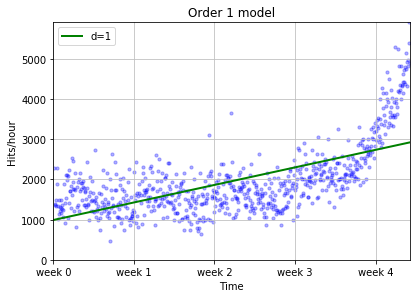

In [13]:
plot_models(x, y, [f1], write_file = os.path.join("1400_01_02.png"),plot_title='Order 1 model')

The green line is our line of predicted values.   The blue dots are what they were before, reality.
So every time a dot lands off the green line, that's an error.  We can say more.  The distance of the
dot from the line is the **magnitude** of out error.  So there are a lot of dots pretty far off the line, especially as we move to the right.  Our model isn't doing a good job of capturing the first thing that caught our eye,  that's a strong upward trend, improving in time.

Well, unfortunately we aren't being surprised.  This model looks pretty bad.  Why is that?  One reason is that we built it with the following line of code.

```
fp1, res, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)
```

That `1` means **Build an order 1 model** and an order 1 model is a straight line.  So what we're trying to
do when we build our model is to find the best straight line to fit our points, and mathematically, there's a pretty good argument that we did. The problem is that no straight line will fit the set of points we've got.

So it's back to the drawing board.

We built three other models besides the straight line model, and we display the results with those models below.
Before we do that, let's note that the line of code that computed the model returned 5 things, one of which, `fp1`,
was used to build `f1`, the function we use for plotting.  Basically, `fp1` is an array of two numbers that
define a straight line:

In [10]:
fp1

array([  2.59619213, 989.02487106])

and we turn those into a function we can use for plotting in this line of code

```
f1 = sp.poly1d(fp1)
```

Let's try using `f1` just to see what it is.

In [15]:

print(f1(1))
print(f1(2))
print(x[1],y[1])
print(f1(3))

991.6210631884607
994.2172553162065
3.0 1386.0
996.8134474439524


Then `f` is a function that returns gradually increasing values.  Give it an `x` (an hour) and it returns a `y` (a predicted number of hits).  It also works on arrays:

In [42]:
f1([1.,2.,3.])

array([ 991.62106319,  994.21725532,  996.81344744])

In what follows we are going to try new models (higher order than 1), each of which will be a function that returns a more complicated shape.  We built functions for those those higher-order models (orders 2, 3, and 10) in the following lines of code.  Note that in this case we build each model in one step by calling `sp.poly1d` on the result returned by `sp.polyfit`.

```
f2 = sp.poly1d(sp.polyfit(x, y, 2))
f3 = sp.poly1d(sp.polyfit(x, y, 3))
f10 = sp.poly1d(sp.polyfit(x, y, 10))
```

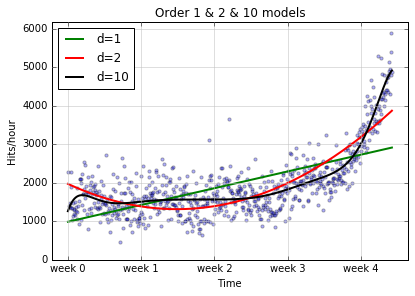

In [13]:
plot_models(x, y, [f1, f2, f10],  write_file = "1400_01_03A.png",plot_title='Order 1 & 2 & 10 models')

The `d=10` model certainly does a better job of following the curvy spine of the data points, but maybe we could do better with an even higher order model:

/Users/gawron/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/gawron/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


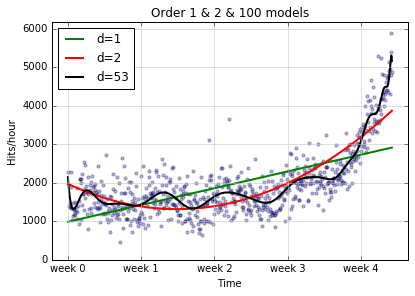

In [14]:
f100 = sp.poly1d(sp.polyfit(x, y, 100))
plot_models(x, y, [f1, f2, f100],  write_file = "1400_01_03B.png",plot_title='Order 1 & 2 & 100 models')

Actually, although we asked for an order 100 model, we didn't have anywhere near enough data to support it;
`numpy` knew this and gave us a warning message.  In addition, it gave us a lower order model than we asked for (look at the legend for the squiggly line), because it just didnt' make sense to make an order 100 model with the data we had.

We can check the actual order of the model we get in the code ourselves as follows:

In [67]:
f100.order

53

Thus `f100` is indeed an order 53 model, which is still pretty high order, as the squiggliness of the above graph attests.  The next question is:  Is this a good thing?   

## Evaluating the prediction success of a model

The main point of this section is very easy to state: If you want to evaluate the prediction performance of a model, test it on some data it never saw.  So we pass in a set of points to estimate the model:  We call this set of points the **training data**.  But we don't let the model see all our data.  We hold some out for the test, and that set is called the **test data**.  This is one of the key ideas of the machine learning paradigm.  Separate training and test; don't let the model in training have any access to information about the test data while it's being trained.

We implement this idea as follows:

In [6]:
# We're going to some random sampling.  To make this code always use the same
# random sample in each run, set the random seed to a known value.
sp.random.seed(7)
frac = 0.1
split_idx = int(frac * len(x))
shuffled = sp.random.permutation(list(range(len(x))),)
test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])
fbt1 = sp.poly1d(sp.polyfit(x[train], y[train], 1))
fbt2 = sp.poly1d(sp.polyfit(x[train], y[train], 2))
fbt3 = sp.poly1d(sp.polyfit(x[train], y[train], 3))
fbt10 = sp.poly1d(sp.polyfit(x[train], y[train], 10))
fbt100 = sp.poly1d(sp.polyfit(x[train], y[train], 100))

/Users/gawron/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/gawron/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [8]:
print(split_idx)
shuffled[:10]

73


array([712, 568, 627, 306, 336, 138, 377, 621, 686, 551])

Next idea:  We need a way of **evaluating** a model.  We have to be able to score the test results.  In this case,
that's pretty easy.  We'll just sum up the differences of what the model predicts for a given hour from what actually happened at that hour.  The higher this score, the worse the model.  One fine point here: any difference between prediction and reality should increase the error score; in particular we want negative differences (predictions that are too low) to be just as bad as those as positive differences (predictions that are too high),  so we'll sum up the **squared differences between predicted values and actual values**.  Here's the code.

In [16]:
def error(f, x, y):
    return sp.sum((f(x) - y) ** 2)

for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print(("Error d=%i: %f" % (f.order, error(f, x[test], y[test]))))

Error d=1: 38634038.655188
Error d=2: 17116769.977369
Error d=3: 10651277.698530
Error d=10: 8720794.977470
Error d=53: 10113992.930632


So what is the best model according to this test?

## Regression

The task our models have been performing for us is called **regression**.  

We take one or more numerical independent variables and try to predict the value of one or more numerical dependent variables.  In this case we used one independent variable (the hour, called `x`) to try to predict one dependent variable (the number of website hits, called `y`). 

For the first-order model in the first graph we considered only straight line models, and because our data had a very pronounced curved spine, we didn't do a very good job of predicting; in fact, our performance grew worse over time.

Let's introduce some terminology which will be helpful later.  A straight line has a constant **slope**.
The slope of a line is the speed with its y-values increase



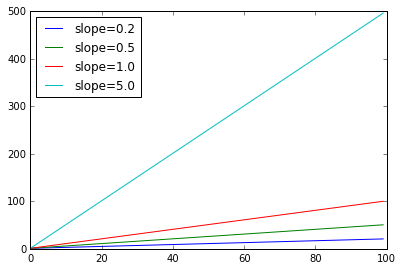

In [9]:
x = sp.arange(100)
slopes = [.2,.5,1.0,5.0]
for s in slopes:
    y = s * x + 1
    plt.plot(x,y)
plt.legend(["slope=%.1f" % s for s in slopes], loc="upper left")

A linear model can model increase but the increase must be at a constant rate.  That rate is the slope of the line. But what if the rate of increase is increasing (that's the curve in our data spine)?  In the next plot, the blue line labeled **nonlin** has an increasing rate of
increase.  In fact it's an order 2 (quadratic) model.  None of the linear models can capture what the blue model is doing, simply because the order 2 model increases at a faster rate.  No matter how high you set the rate of change ion a linear model, sooner or later a quadratic model will catch up.

In [10]:
x = sp.arange(100)
slopes = [.2,1.0,5.0]
for s in slopes:
    y = s * x + 1
    plt.plot(x,y)
plt.xlim([0,20])
plt.ylim([0,200])
plt.plot(x,x**2)
legs = ["slope=%.1f" % s for s in slopes]
legs += ["slope = nonlin"]
plt.legend(legs, loc="upper left")

The curves in higher order models don't have a constant slope, so they can do a little better at modeling the increasing rate of increase in order web site traffic data.

## Homework questions

1.  How many rows and columns are there in the web traffic data?  How many `nan` values are there in the hit counts column?

2.  What is the difference between `y_init` and `y_filtered`?  What is the array `mask` used for?

3.  What does the function `error` do?

4.  What is the difference between a linear model and a higher-order model?  Why do the higher-order models do better on the web-site traffic data?

5.  What is the actual order of the highest order model that was run on the web-site traffic data  in the code above?

6.  Here is some more web traffic data.

    ```
    data_file = os.path.join(data_dir, "web_traffic2.tsv")
    ```
    
    Write some code to read in this data and do a scatter plot of the data.  You do not have 
    to create any models. Put the code in the cell below. Do not import any modules that have     already been imported in the code above.
    
    Now look at the plot. What is happening around Week 3 that might be worthy of notice?



In [2]:
from sklearn import datasets
boston = datasets.load_boston()
X,Y = boston.data,boston.target
feature_names = boston.feature_names
print(X.shape, Y.shape)

(506, 13) (506,)


7) The cell above loads the `sklearn` version of data on Boston house prices, originally the UCI ML Housing data set.  The next cell prints out the description.  The first 13 attributes described are stored in a 506x13 array we call `X` in the cell above.  The 14th attribute (MEDV) is stored separately in `Y` because it is usually the value we are trying to predict.
Write some code to do a scatter plot of CRIM vs MEDV.